## Erstellen eines Prognosemodells für den Energieverbrauch


Dieses Notebook zeigt
- wie man mithilfe eines Entscheidungsbaums ein Vorhersagemodell für den Energieverbrauch erstellen kann
- wie man die Modell-Performance bewerten kann
- wie man die Modell-Performance optimieren kann (Hyperparameteroptimierung)

In [1]:
### Bibliotheken einbinden

## Datenanalyse
import pandas as pd
import numpy as np

## Plotten
import matplotlib.pyplot as plt
# zeige Plots in Zellen des Notebooks an
%matplotlib inline 
import seaborn as sns
# setze seaborn style defaults und Default-Wert für Plotgröße
sns.set(rc={'figure.figsize':(20, 10)}) 

## Maschinelles Lernen
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.tree import export_text
from sklearn import tree
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Aufgabe 1
Lesen Sie den Datensatz Energieverbrauch.csv ein und geben Sie sich die ersten Spalten aus.

In [2]:
data = pd.read_csv('./data/Energieverbrauch.csv')
data.head()

,Date,Consumption
0,2012-01-01,948.128
1,2012-01-02,1269.581
2,2012-01-03,1334.745
3,2012-01-04,1347.136
4,2012-01-05,1376.658


## Aufgabe 2
- Sie wollen ein Vorhersagemodell für den Energiebedarf erstellen.
- Indizieren Sie dazu zunächst das Dataframe mit dem Zeitstempel. 
- Vergessen Sie dabei nicht, das Datenformat der Spalte Date falls nötig zu ändern

In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.head()

,Consumption
Date,
2012-01-01,948.128
2012-01-02,1269.581
2012-01-03,1334.745
2012-01-04,1347.136
2012-01-05,1376.658


## Aufgabe 3
- Für das Vorhersagemodell wollen Sie folgende Merkmale heranziehen: 
    Jahr, Monat, Wochentag (0,1,2,3...,6 für Mo-So)
- Solche zeitlichen Merkmale können Sie ganz leicht mithilfe des Zeitstempel-Index generieren. 
- Für den Wochentag wurde das unten beispielhaft schon durchgeführt. 
- Fügen Sie auf ähnliche Weise zwei weitere Spalten mit den Merkmalen Jahr und Monat ein. Hinweis: Verwenden Sie dazu die Attribute year und month des index.
- Geben Sie sich Teile des Dataframes aus und inspizieren Sie die neu hinzugefügten Merkmale.

In [4]:
data['Weekday'] = data.index.weekday
data['Year'] = data.index.year
data['Month'] = data.index.month

## Aufgabe 4
- Weiterhin wollen Sie das Merkmal Wochenende 0/1 generieren. 
- Wie das funktioniert, sieht man in der unteren Zelle.
- Gehen Sie den Code durch und versuchen Sie zu verstehen, was passiert

In [5]:
data['Weekend'] = [0 if x < 5 else 1 for x in data.index.weekday]
# Weekend wird 0 für Montag bis Freitag (0 bis 4) und 1 für Samstag und Sonntag (5 und 6)

## Aufgabe 5
- Unten kommt eine Zelle mit einer Hilfsfunktion. Sie müssen die Zelle einfach nur ausführen. Die Funktion an sich müssen Sie nicht verändern. 
- Versuchen Sie zu verstehen, was passiert. 

### Was macht die Hilfsfunktion?

**Antwort:**

Das Dataframe wird aufgeteilt, um Daten zum Trainieren, Validieren und Testen zu haben. Die df-Teilmengen werden somit in eigenen Variablen abgespeichert.

Das Label wird mit den Werten der Spalten gesetzt.

Zuletzt werden die Merkmale aus den Daten entfernt.

In [6]:
# Hilfsfunktion
def generate_sets(df): 
    
    # Spalte df auf in Trainings-, Validierungs- und Testmenge in den Anteilen 60%, 20%, 20%
    df_train, df_validate, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])        
        
    # Auswahl der Label durch Auswahl der entsprechenden Spalten                 
    y_train = df_train['Consumption']
    y_validate = df_validate['Consumption']
    y_test = df_test['Consumption']
        
    # Merkmale nicht in des Modell einbeziehen und somit die jeweiligen Spalten aus dem Datensatz entfernen
    X_train = df_train.drop(['Consumption','Year'], axis=1)
    X_validate = df_validate.drop(['Consumption','Year'], axis=1)
    X_test = df_test.drop(['Consumption','Year'], axis=1)                                                                          
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test
    

## Aufgabe 6
### 1. *Oben in der Hilfsfunktion wird das Merkmal `Year` aus den Datensätzen entfernt und nicht in das Modell einbezogen. Warum macht das Sinn?*
- Das Merkmal `Year` ist bezüglich des Stromverbrauchs irrelevant.
<br/><br/>
### 2. *Weiterhin wird aus `X_train/validate/test` die Spalte `Consumption` gelöscht. Wieso macht das Sinn?*
- Der Wert von `Consumption` wird in `y_train/validate/test` gespeichert.
<br/><br/>
### 3. *Wozu braucht man Trainings-, Validierungs- und Testmenge?*
- Die Phasen *Training*, *Validierung* und *Test* benötigen jeweils alle Daten. <br>
Die Daten müssen sich aber unterscheiden, weil der Test mit einem Datensatz keinen Sinn ergibt, in dem Falle, dass genau die identischen Daten beim Training benutzt wurden.

- Deswegen bietet es sich an den vorhanden Datensatz für alle drei Phasen aufzuteilen und zu verwenden.

In [12]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit der Hilfsfunktion:
X_train, y_train, X_val, y_val, X_test, y_test = generate_sets(data)

## Aufgabe 7
- Es folgt eine Hilfsfunktion zum Trainieren eines Entscheidungsbaum und der graphischen Ausgabe des trainierten Baumes.
- Auch an dieser Funktion müssen Sie nichts ändern.
- Vielleicht verstehen Sie Teile der Funktion?
- Schauen Sie sich an, wie man Funktionen zum leichteren Verständnis mittels ''' ''' kommentieren kann

In [10]:
# Hilfsfunktion 2
def train_decision_tree(X_train, y_train, min_samples_split = 2, min_samples_leaf = 1, output=False):
    '''
    Hilfsfunktion zum Trainieren eines Entscheidungsbaumes auf einer Trainingsmenge.
    
    Inputs: 
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    min_samples_split (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Split,
                                        wenn int, Mindestanzahl Samples in jedem Split
    min_samples_leaf (float oder int): wenn float, prozentualer Mindestanteil an Samples in jedem Blatt des Entscheidungsbaumes,
                                        wenn int, Mindestanzahl Samples in jedem Blatt
    output (bool): ob eine Ausgabe erzeugt werden soll (Die Ausgabe enthält die Regeln des Entscheidungsbaumes und eine graphische 
                   Darstellung des Entscheidungsbaumes)
                   
    Outputs:
    dtr: ein auf der Trainingsmenge trainierter Entscheidungsbaum, der nachfolgend zur Prognose verwendet werden kann          
    '''
    
    # Spaltennamen (=Namen der Merkmale) für später speichern
    feature_names = list(X_train.columns)
    
    # Dataframes in numpy arrays konvertieren, da der Entscheidungsbaum das als Input benötigt
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    #Entscheidungsbaum mit bestimmten Hyperparametern (min_samples_split und min_samples_leaf intialisieren)
    dtr = DecisionTreeRegressor(random_state = 0, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    
    # Entscheidungsbaum trainieren
    dtr.fit(X_train, y_train)
    
    # Optionale Ausgabe generieren
    if output:
        
        rules = export_text(dtr, feature_names = feature_names)
        print(rules)
        print('Folgende Merkmale waren verfügbar:', feature_names)
        
        with plt.style.context('classic'):
            plt.figure(figsize=(20,10))
            tree.plot_tree(dtr, filled=True, impurity=True, rounded=True, feature_names=feature_names)
    
    return dtr

### Aufgabe 8:
- Als nächstes wollen wir einen Entscheidungsbaum auf dem Trainingsdatensatz trainieren. 
- Dazu wird die Hilfsfunktion train_decision_tree herangezogen. 
- Diese enthält die Parameter min_samples_split und min_samples_leaf
___
- *Was bedeuten diese Parameter? 
Versuchen Sie dies mithilfe der [Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) zu klären:*

    - **`min_samples_split` ist die Mindestanzahl von Samples, die benötigt wird, um einen Node aufzuspalten.** <br> <br> Dies hat einen linearen Zusammenhang mit der Datenmenge - *je mehr Daten gefordert werden, umso mehr werden benötigt, um eine Differenzierung durchzuführen.* <br> <br>
    - **`min_samples_leaf` ist die Mindestanzahl von Samples, die für einen Blattknoten erforderlich sind.**<br><br> Ein Aufteilungspunkt in beliebiger Tiefe wird nur berücksichtigt, wenn er *mindestens min_samples_leaf Trainingsstichproben* **in jedem der linken und rechten Zweige** hinterlässt.
<br> <br>
- *Was passiert wenn Sie diese Parameter verändern?*
    - Je nachdem wie man `min_samples_split` verändert, ändert sich die **Verfeinerung des Baums** nach der Zahl der Splits. *Je höher der Wert, umso weniger Splits stattfinden.*
    <br> <br>
    - Je nachdem wie man `min_samples_leaf` verändert, ändert sich die Anzahl der Blättern im Baum. *Ein höherer Wert führt zu weniger Blättern im Baum, da jeder Endknoten mehr Datenpunkte enthalten muss.* <br> <br>
___
- Führen Sie die Funktion in der untenstehenden Zelle mehrfach aus und variieren Sie dabei z.B. *min_samples_split zwischen 2 und 2000*. <br> Probieren Sie mindestens 10 verschiedene Werte in diesem Bereich aus und betrachten den entstehenden Entscheidungsbaum <br> <br>

    - Ändert man das *`min_samples_split` Parameter auf e.g. 2000*, wird **nur noch ein großer Knoten** erzeugt, weil nicht genügend Samples vorhanden sind, um den Knoten aufzuspalten. <br> 
    Stellt man *`min_samples_split` auf e.g. 50*, werden deutlich mehr Knoten erzeugt, weil weniger Samples pro Knoten benötigt werden, um diesen aufzuteilen. <br> <br>
    - Ändert man den `min_samples_leaf` kann man erkennen, dass **die Knoten immer mindestens die angegebene anzahl an Samples einhalten.** <br>
    Somit werden abhängig von der Anzahl an Samples die Knoten weiter aufgeteilt oder zusammen gehalten <br>

|--- Weekend <= 0.50
|   |--- Month <= 3.50
|   |   |--- value: [1503.37]
|   |--- Month >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 4.50
|   |   |   |   |--- value: [1402.39]
|   |   |   |--- Month >  4.50
|   |   |   |   |--- Month <= 8.50
|   |   |   |   |   |--- Weekday <= 2.50
|   |   |   |   |   |   |--- value: [1356.23]
|   |   |   |   |   |--- Weekday >  2.50
|   |   |   |   |   |   |--- value: [1337.60]
|   |   |   |   |--- Month >  8.50
|   |   |   |   |   |--- value: [1397.96]
|   |   |--- Month >  9.50
|   |   |   |--- value: [1460.92]
|--- Weekend >  0.50
|   |--- Weekday <= 5.50
|   |   |--- value: [1212.08]
|   |--- Weekday >  5.50
|   |   |--- value: [1120.40]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']


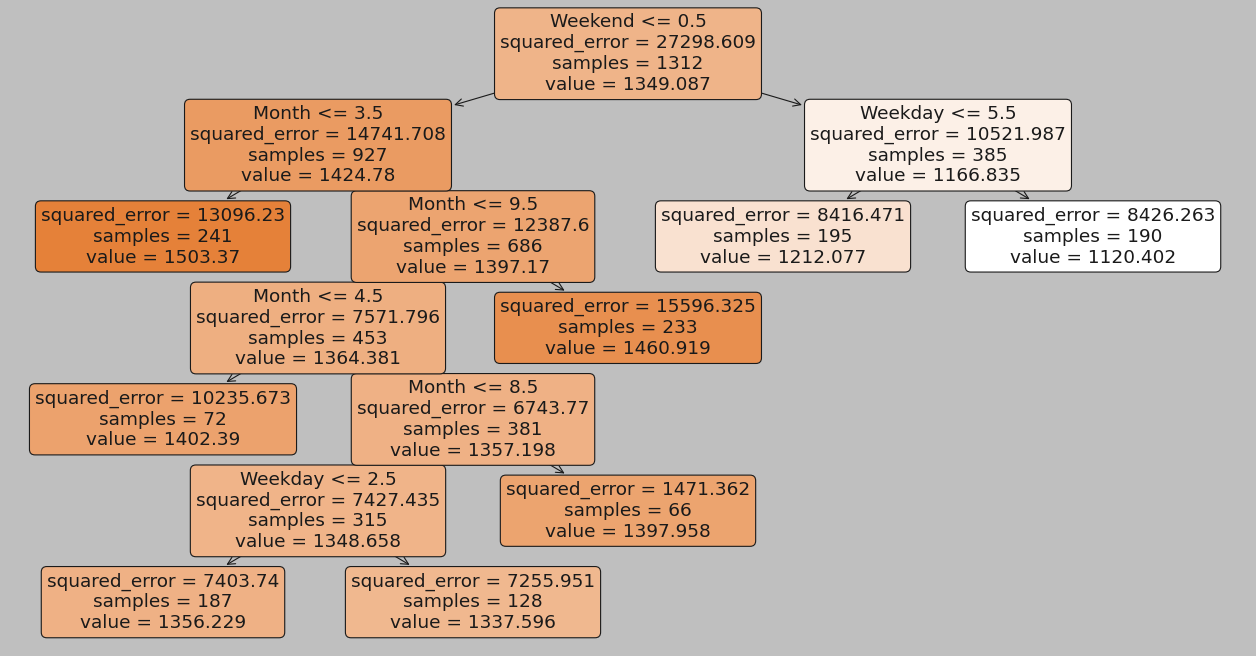

In [43]:
# Datensatz aufteilen in Trainings-, Validierungs- und Testmenge mit Hilfsfunktion generate_sets
trained_decision_tree = train_decision_tree(X_train, y_train, min_samples_split = 300, min_samples_leaf = 1, output=True)

- Es folgt eine weitere Hilfsfunktion zur Vorhersage des Energieverbrauchs mithilfe des zuvor trainierten Entscheidungsbaums
- Auch an dieser Funktion müssen Sie nichts ändern und wir sprechen sie gemeinsam durch.
- Wichtig: mit dieser Funktion kann man testen, wie gut die Vorhersage auf der Validierungsmenge funktioniert, siehe Aufgabe 8

In [46]:
# Hilfsfunktion 3
def predict_with_decision_tree(dtr, X_val, y_val, output=True):
    '''
    Hilfsfunktion zur Erstellung einer Vorhersage auf Basis eines trainierten Entscheidungsbaumes und zur Ausgabe der Gütemaße.
    
    Inputs: 
    dtr: ein zuvor auf einer Trainingsmenge trainierter Entscheidungsbaum, der zur Prognose verwendet werden kann  
    X_val (df): Dataframe mit den Merkmalsvektoren der Validierungsmenge
    y_val (df): Dataframe mit den Labeln der Validierungsmenge
    output (bool): ob eine print-Ausgabe erzeugt werden soll (enthält Gütemaße), standardmäßig auf True.
   
    Outputs:
    y_pred (np.array): Vorhersage des Entscheidungsbaumes für die Merkmalsvektoren der Validierungsmenge   
    metrics_dict (dict): Dictionary mit den Metriken zur Bewertung der Vorhersagegüte
    '''  
    
    # Vorhersage für Validierungsmenge mit Entscheidungsbaum generieren
    y_pred = dtr.predict(X_val)
    
    ## Metriken zur Bewertung der Vorhersagegüte berechnen
    # Absoluten Fehler berechnen: Betrag der Differenz zwischen Vorhersage und den tatsächlichen Label der Validierungsmenge
    abs_errors = abs(y_pred - y_val)

    # Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae = mean_absolute_error(y_val, y_pred)
    
    # Relativen Mean Absolute Error (MAE) durch Bilden des Mittelwertes berechnen
    mae_rel = mae/np.mean(y_val)
    
    # Mean Absolut Percentage Error (MAPE) berechnen
    mape = np.mean(abs_errors/y_val)
    
    # Mean Squared Error 
    mse = mean_squared_error(y_val, y_pred) 
    
    # Root Mean Squared Error
    rmse = np.sqrt(mse) / np.mean(y_val)
    
    metrics_dict = {'mae': mae,
                    'mse': mse,
                    'mae%': mae_rel*100,
                    'mape%': mape*100,
                    'rmse%': rmse*100
                   }
    
    if output:
        print('Mittelwert der wahren Label', round(np.mean(y_val), 2))
        print('MAE', round(mae, 4))
        print('MSE', round(mse, 4))
        print('MAE', mae_rel*100, '%')
        print('MAPE', mape*100, '%')
        print('RMSE', rmse*100, '%')
            
    return y_pred, metrics_dict

## Aufgabe 8
- Mit dem trainierten Entscheidungsbaum (trained_decision_tree) werden im nächsten Schritt Vorhersagen für die Validierungsmenge erstellt
- Die Vorhersagen des Entscheidungsbaums werden innerhalb von *Hilfsfunktion 3* mit den tatsächlichen Labeln der Validierungmenge verglichen
- Verschiedene Metriken zur Bewertung der Güte der Regression können herangezogen werden, s. Vorlesung
___
- Was bedeutet die einzelnen Metriken, die nach Ausführen der nächsten Zelle ausgegeben werden?
- Ist das Prognosemodell gut?


Antwort:
- **Mean Absolute Error (MAE)** ist der Durchschnitt der absoluten Differenz zwischen prognostizierten Werten und wahren Werten. *Eine MAE von 0 bedeutet, dass kein Fehler in den prognostizierten Werten vorliegt.* <br> <br>
- **Mean Squared Error (MSE)** ist der erwartete quadratische Abstand des Schätzwerts. Dies definiert die Qualität des Prognosemodells, beinhaltet die Varianz als auch die Verzerrung. *Je näher der Wert an 0 liegt, desto besser ist das Modell.*
Der vorliegende Wert von ca. **10243.0265** ist also nicht gut. <br> <br>
- **Mean Absolute Error (MAE) in %** ist die Normierung von *MAE*. Dazu wird der *MAE* durch den Mittelwert der erwarteten Werte geteilt. Also konkret sind ca. ***5.55%** der Werte nicht richtig.* <br> <br>
- **Mean Absolut Percentage Error (MAPE)** ist der prozentuale Mittelwert der absoluten Differenz zwischen prognostizierten Werten und wahren Werten, geteilt durch den wahren Wert. Auch hier ist ein niedriger Wert besser.<br> <br>
- **Root Mean Squared Error (RMSE)** gibt an wie stark eine Prognose im durchschnitt von den tatsächlichen Beobachtungswerten abwiecht. Wird berechnet auf der Quadratwurzel des durchschnittlichen Prognosefehlers.
Je größer der RMSE, desto schlechter ist dieser.
*Mit einem Wert von ca. **7.46%** ist dieser nicht gut.* <br> <br>
- `Das Prognosemodell ist nach den Erklärungen nicht gut, da die Abweichungen zu groß sind.`

In [48]:
# Erzeuge mit dem Trainierten Entscheidungsbaum eine Vorhersage für das Validierungsset
y_pred, metrics_dict = predict_with_decision_tree(trained_decision_tree, X_val, y_val, output=True)

Mittelwert der wahren Label 1355.47
MAE 75.2524
MSE 10243.0265
MAE 5.551739477486676 %
MAPE 5.839007410222565 %
RMSE 7.466600119973722 %


/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


## Aufgabe 9
- Wir wollen ein gute Wahl für den Hyperparameter min_samples_split treffen.
- Dafür gibt es Hilfsfunktion 4. Können Sie erkennen, was in der Hilfsfunktion passiert?
- Versuchen Sie einen Kommentar zu verfassen, der die Hilfsfunktion beschreibt.

In [50]:
# Hilfsfunktion 4
def optimize_hyperparam(X_train, y_train, X_val, y_val, metric='mae%'):
    '''
    Hilfsfunktion zur Optimierung der Hyperparameter 
    
    Inputs: 
    X_train (df): Dataframe mit den Merkmalsvektoren der Trainingsmenge
    y_train (df): Dataframe mit den Labeln der Trainingsmenge
    X_val (df): Dataframe mit den Merkmalsvektoren der Validierungsmenge
    y_val (df): Dataframe mit den Labeln der Validierungsmenge
    metric (string): den erwarteten Metric Typ, standardmäßig auf 'mae%' gesetzt.
   
    Outputs:
    metrics_list (list): Liste mit den Metriken für die verschiedenen Werte des Hyperparameters
    best_metric (float): bester Wert für die ausgewählte Metrik
    best_min_split (int): bester Wert für den Hyperparameter min_samples_split

    ''' 
    
    # Anzahl der Beobachtungen bestimmen, funktioniert über Zeilenanzahl von X_train.
    number_of_samples = X_train.shape[0]
    
    # Noch leere Liste für Metriken erstellen, die später sukzessive gefüllt wird.
    metrics_list = []
    
    # Optimalen Wert für Metrik mit großer Zahl initialisieren
    best_metric = 100000
    
    ## Schleife zum Optimieren des Hyperparameters min_samples split
    # min_samples_split wird auf Werte zwischen 2 und int(np.floor(1/5*number_of_samples)) gesetzt und in Einserschritten erhöht.
    # Für jedes gesetzte min_samples_split wird ein Entscheidungsbaum trainiert 
    # und dessen Performance anhand der Validierungsmenge getestet
    for min_samples_split in range(2, int(np.floor(1/3*number_of_samples))):
        
        # Trainieren eines Entscheidungsbaums mit bestimmtem Wert für min_samples_split 
        decision_tree = train_decision_tree(X_train, y_train, min_samples_split = min_samples_split, output=False)
        
        # Auswerten der Performance des Entscheidungsbaums durch Einsetzen der Validierungsmenge 
        # und Vergleich der vorhergesagten Label y_pred mit den wahren Labeln y_val
        y_pred, metrics_dict = predict_with_decision_tree(decision_tree, X_val, y_val, output=False)
        metrics_list.append((min_samples_split, metrics_dict))
        
        # Finden des optimalen Werts für min_samples_split
        if metrics_dict[metric] <= best_metric:
            best_metric = metrics_dict[metric]
            best_min_split = min_samples_split 
            
    ## Plotten der Ergebnisse 
    # Linienplot mit (x=Werte für min_samples_split, y=Wert der ausgewählten Metrik)
    plt.figure(figsize=(20,10))
    sns.lineplot(x=[i[0] for i in metrics_list], y=[i[1][metric] for i in metrics_list])
    # Vertikale Linie bei x=best_min_split
    plt.axvline(x=best_min_split, color='k', linestyle = '--')
    # Horizontale Linie bei dazugehörigem y, sowie Legende erzeugen
    plt.axhline(y=best_metric, color='k', linestyle = '--', 
                label='Bester Wert für min_samples_split: ' + str(best_min_split) + '\n' + metric + ': ' + str(best_metric))
    plt.legend()
    
    # Ausgabe der Funktion
    return metrics_list, best_metric, best_min_split


## Aufgabe 10
- Führen Sie die obige Zelle aus, sodass die Funktion optimize_hyperparam() definiert wird.
- Wenden Sie anschließend die Funktion optimize_hyperparam() an durch ausführen der unteren Zelle und bestimmen Sie metrics_list, best_metric und best_min_split
___
- Wie interpretieren Sie den erzeugten Plot? <br> <br>
    - Je größer der Wert von `min_samples_split` ist, desto mehr Fehler in den prognostizierten Werten vorliegen. Das ist auf den steigenden Wert von `Mean Absolute Error` zurückzuführen. <br> <br>
- Wie sollten Sie den Hyperparameter min_samples_split setzen? <br> <br>
    - Es wird von der Methode `optimize_hyperparam()` der optimalste Wert für `min_samples_split` *(in dem Fall 81)* als drittes Ergebnis zurückgegeben und auf das Linienplot gezeigt.

/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, bu

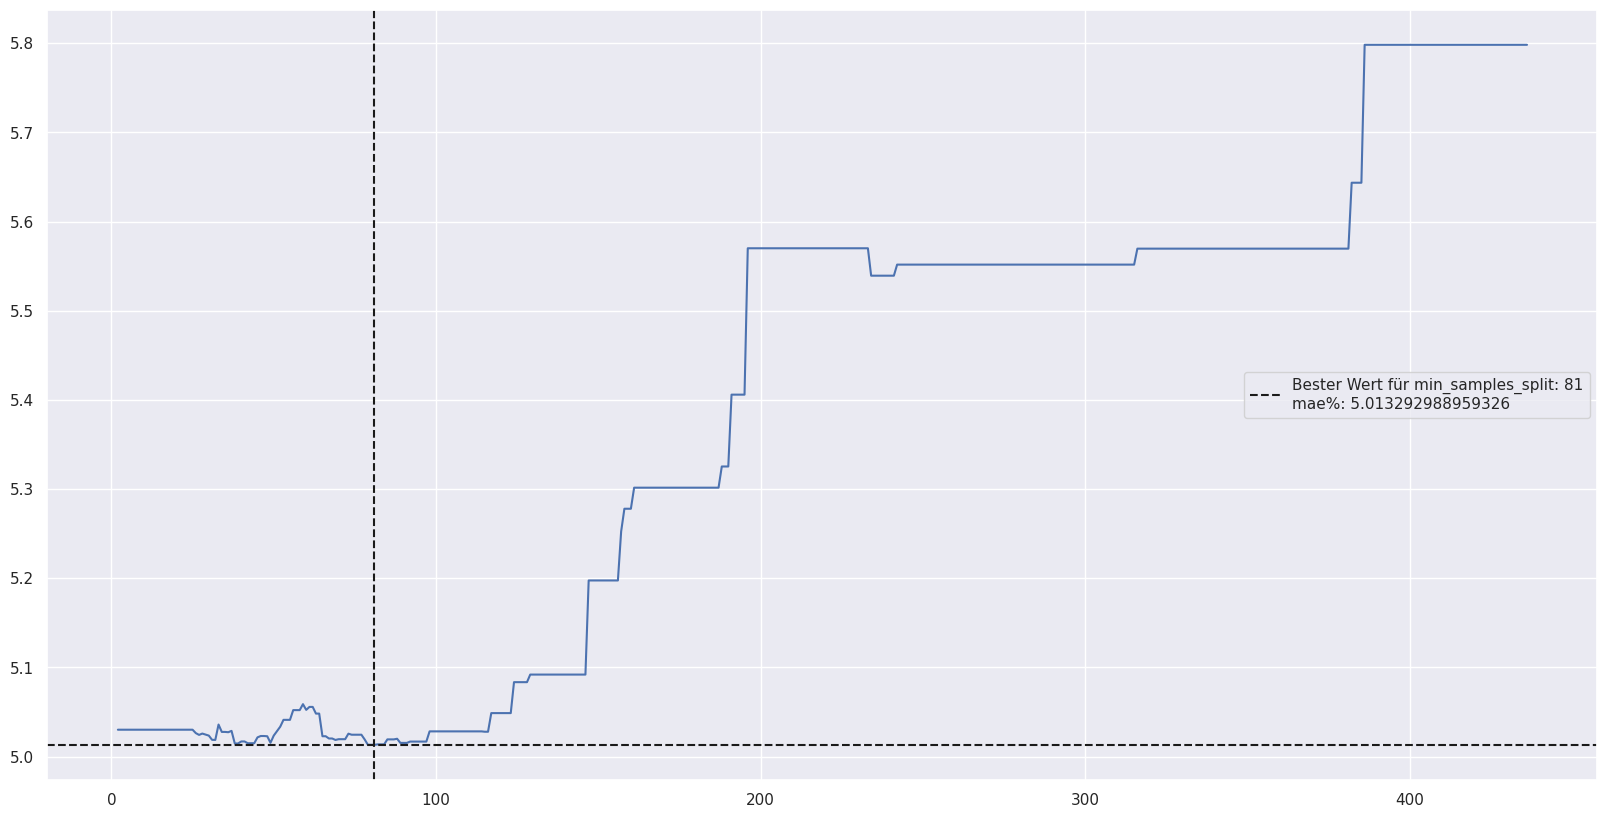

In [51]:
metrics_list, best_metric, best_min_split = optimize_hyperparam(X_train, y_train, X_val, y_val) 

## Aufgabe 11
- Trainieren Sie erneut einen Entscheidungsbaum und setzten Sie dabei gezielt min_samples_split auf den gefundenen optimalen Wert, indem Sie die unten stehende Funktion ausführen.

|--- Weekend <= 0.50
|   |--- Month <= 3.50
|   |   |--- Month <= 2.50
|   |   |   |--- Month <= 1.50
|   |   |   |   |--- Weekday <= 3.50
|   |   |   |   |   |--- value: [1515.84]
|   |   |   |   |--- Weekday >  3.50
|   |   |   |   |   |--- value: [1496.84]
|   |   |   |--- Month >  1.50
|   |   |   |   |--- value: [1541.44]
|   |   |--- Month >  2.50
|   |   |   |--- Weekday <= 3.50
|   |   |   |   |--- value: [1473.41]
|   |   |   |--- Weekday >  3.50
|   |   |   |   |--- value: [1422.16]
|   |--- Month >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 4.50
|   |   |   |   |--- value: [1402.39]
|   |   |   |--- Month >  4.50
|   |   |   |   |--- Month <= 8.50
|   |   |   |   |   |--- Weekday <= 2.50
|   |   |   |   |   |   |--- Weekday <= 0.50
|   |   |   |   |   |   |   |--- value: [1336.87]
|   |   |   |   |   |   |--- Weekday >  0.50
|   |   |   |   |   |   |   |--- Month <= 7.50
|   |   |   |   |   |   |   |   |--- Month <= 6.50
|   |   |   |   |   |   |   |   |   |-

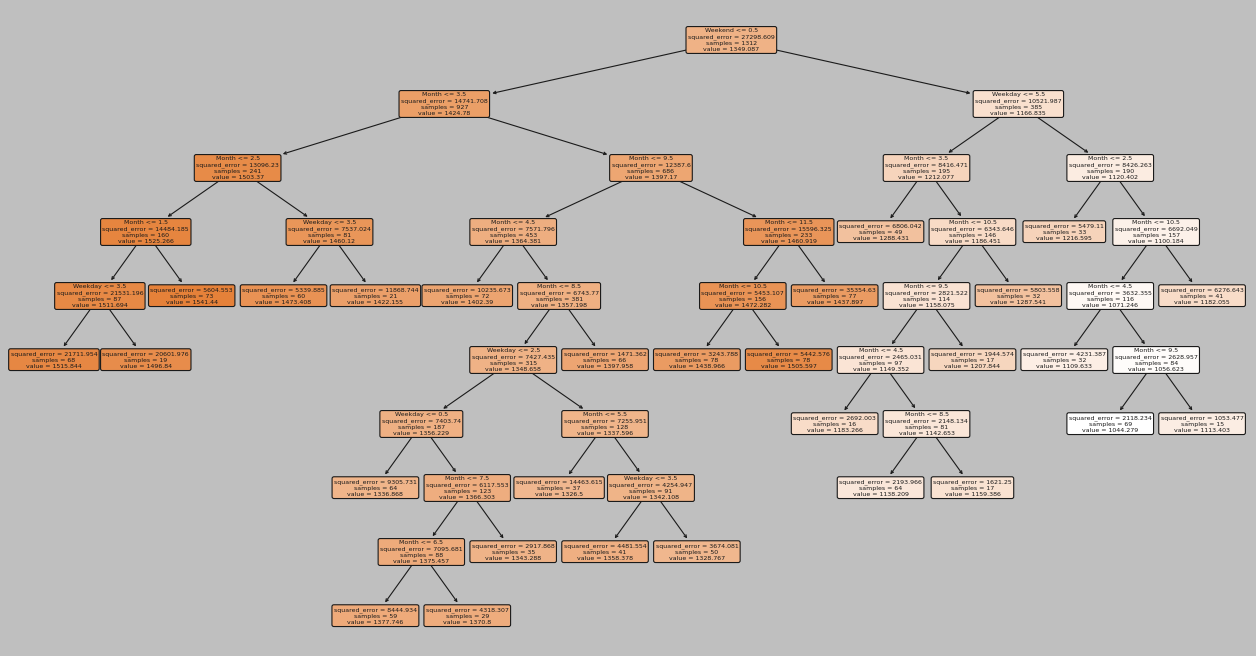

In [53]:
# Trainiere Entescheidungsbaum mit min_samples_split = best_min_split
# best_min_split ist dabei der beste gefundene Wert für diesen Hyperparameter aus der Optimierungs oben.
decision_tree_large = train_decision_tree(X_train, y_train, min_samples_split = best_min_split, output=True)

- Was sagen Sie zu dem Ergebnis? <br> <br>
    - Der `MAE` ist deutlich besser geworden. Allerdings ist der Baum nun sehr schwer lesbar und sehr unübersichtlich. <br> <br>
- Wenn Sie mit einem *Fehler % `MAE` <= 7%* zufrieden wären, welche Werte für best_min_split könnten Sie setzen? Welchen Wert würden Sie wählen, um eine gute Interpretierbarkeit des Baumes durch den Menschen zu gewährleisten? <br> <br>
    - Mit **`min_samples_split` = 450** ist der Baum noch aussagekräftig aber gleichzeitig gut nachvollziehbar.

|--- Weekend <= 0.50
|   |--- Month <= 3.50
|   |   |--- value: [1503.37]
|   |--- Month >  3.50
|   |   |--- Month <= 9.50
|   |   |   |--- Month <= 4.50
|   |   |   |   |--- value: [1402.39]
|   |   |   |--- Month >  4.50
|   |   |   |   |--- value: [1357.20]
|   |   |--- Month >  9.50
|   |   |   |--- value: [1460.92]
|--- Weekend >  0.50
|   |--- value: [1166.83]

Folgende Merkmale waren verfügbar: ['Weekday', 'Month', 'Weekend']
Mittelwert der wahren Label 1355.47
MAE 78.5933
MSE 11096.3993
MAE 5.798217772467266 %
MAPE 6.12455595616672 %
RMSE 7.7714093182103 %


/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


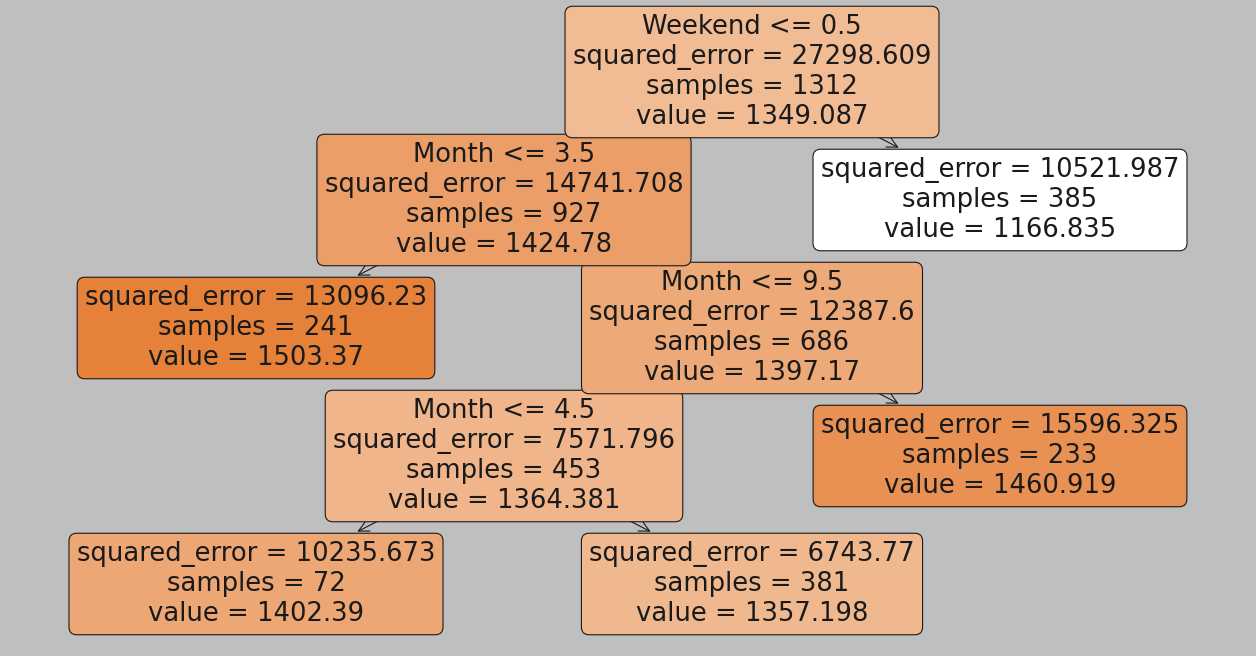

In [61]:
# Trainiere einen kleineren Entscheidungsbaum durch setzen eines anderen Wertes für min_samples_split, sodass mae% vertretbar

# Diese Zeile wieder einkommentieren und anpassen
decision_tree_smaller = train_decision_tree(X_train, y_train, min_samples_split = 450 , output=True) 


# Überprüfe Performance auf Validierungsmenge
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_val, y_val, output=True)

## Aufgabe 12
- Prüfen Sie die Performance des großen und des kleinen Entscheidungsbaumes auf dem Testset.
- Wie interpretieren Sie die Ergebnisse? Wäre der kleine Entscheidungsbaum vertretbar?


*Antwort:* <br>
Die Abweichungen der relativen Metriken weichen *ungefähr um einen Prozent* voneinander ab. In Betracht der Komplexität des großen Entscheidungsbaums ist der kleinere Entscheidungsbaum durchaus vertretbar.<br> <br>
Da der kleine Entscheidungsbaum ein geringes Niveau hat, kann man daraus schließen, dass die zusätzliche Menge an Fehlern (~0.86%), die der kleine Entscheidungsbaum mehr macht, durch die Komplexität der unteren Ebenen des großen Entscheidungsbaums ersetzt werden. <br> <br>
**Man muss also zwischen Komplexität und eine größere MAE abwiegen.** 

In [64]:
# Performance des großen Entscheidungsbaums auf dem Testset
print('Performance des großen Entscheidungsbaums')
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_large, X_test, y_test, output=True)

# Ausgabe einer leeren Zeile für die Übersichtlichkeit
print()

# Performance des kleinen Entscheidungsbaums auf dem Testset
print('Performance des kleinen Entscheidungsbaums')
y_pred, metrics_dict = predict_with_decision_tree(decision_tree_smaller, X_test, y_test, output=True)

Performance des großen Entscheidungsbaums
Mittelwert der wahren Label 1334.89
MAE 68.5276
MSE 9563.5475
MAE 5.133597642727563 %
MAPE 5.399759860070195 %
RMSE 7.325976921415965 %

Performance des kleinen Entscheidungsbaums
Mittelwert der wahren Label 1334.89
MAE 79.9781
MSE 11996.1382
MAE 5.9913819146375324 %
MAPE 6.391334689639534 %
RMSE 8.204965644315905 %


/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/home/chris/.local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
